<a href="https://colab.research.google.com/github/Harry160820/Human-Activity-Reconviction-Sysytem-/blob/main/Human_Activity_Recoginition_system.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Set Up Google Colab Environment

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
file_path = '/content/drive/MyDrive/HAR_dataset'

# 2. Import Libraries

In [ ]:
import pandas as  pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.utils import to_categorical

In [ ]:
activity_files = ["Cycling.csv", "Football.csv", "Jogging.csv", "JumpRope.csv", "Pushups.csv",
                  "Sitting.csv", "Swimming.csv", "Tennis.csv", "Walking.csv", "WalkingUpstairs.csv", "WalkingDownstairs.csv"]

# 3. Load and Explore Dataset

In [ ]:
#combine all activity into one dataframe

data_frames = []

for activity in activity_files:
    df = pd.read_csv(f"{file_path}/{activity}")
    activity_label = activity.split('.')[0] #get name of the file
    df['activity'] = activity_label
    data_frames.append(df)

#concatinate all data frames
data = pd.concat(data_frames, ignore_index = True)
#check structure and summary
print(data.head())
print(data.info())
print(data['activity'].value_counts())

   ACCELEROMETER X (m/s²)  ACCELEROMETER Y (m/s²)  ACCELEROMETER Z (m/s²)  \
0                 -0.8857                 -0.9150                  9.5503   
1                 -0.8139                  1.2541                  9.4306   
2                -10.2466                -11.1079                 16.0610   
3                 -4.3679                 -7.6616                 -4.6180   
4                  5.0936                 -7.1863                 -5.2249   

   GRAVITY X (m/s²)  GRAVITY Y (m/s²)  GRAVITY Z (m/s²)  \
0           -1.1034           -0.0603            9.7442   
1           -0.5532            1.0615            9.7333   
2            0.9801            6.8492           -6.9497   
3            3.5523           -8.1039           -4.2283   
4            4.0020           -8.0153           -3.9886   

   LINEAR ACCELERATION X (m/s²)  LINEAR ACCELERATION Y (m/s²)  \
0                       -0.6645                        0.8831   
1                       -1.8757                     

# 4. Data Preprocessing

In [ ]:
# drop Time since start in ms as we do not need it
columns_to_be_deleted = ['Time since start in ms', 'YYYY-MO-DD HH-MI-SS_SSS' ]

for i in columns_to_be_deleted:
  data = data.drop(i, axis=1)


In [ ]:
data.head()

,ACCELEROMETER X (m/s²),ACCELEROMETER Y (m/s²),ACCELEROMETER Z (m/s²),GRAVITY X (m/s²),GRAVITY Y (m/s²),GRAVITY Z (m/s²),LINEAR ACCELERATION X (m/s²),LINEAR ACCELERATION Y (m/s²),LINEAR ACCELERATION Z (m/s²),GYROSCOPE X (rad/s),...,activity,ACCELEROMETER X (m/sÂ²),ACCELEROMETER Y (m/sÂ²),ACCELEROMETER Z (m/sÂ²),GRAVITY X (m/sÂ²),GRAVITY Y (m/sÂ²),GRAVITY Z (m/sÂ²),LINEAR ACCELERATION X (m/sÂ²),LINEAR ACCELERATION Y (m/sÂ²),LINEAR ACCELERATION Z (m/sÂ²)
0,-0.8857,-0.9150,9.5503,-1.1034,-0.0603,9.7442,-0.6645,0.8831,0.6781,-1.0842,...,Cycling,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-0.8139,1.2541,9.4306,-0.5532,1.0615,9.7333,-1.8757,0.1955,-0.1211,0.2783,...,Cycling,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,-10.2466,-11.1079,16.0610,0.9801,6.8492,-6.9497,4.7212,-7.9441,-9.0559,-1.0009,...,Cycling,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,-4.3679,-7.6616,-4.6180,3.5523,-8.1039,-4.2283,2.8049,-3.7581,-7.1497,0.0703,...,Cycling,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5.0936,-7.1863,-5.2249,4.0020,-8.0153,-3.9886,5.1214,-3.4253,3.9980,-0.4245,...,Cycling,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


4.1 Handling missing values

In [ ]:
from sklearn.impute import KNNImputer
#check for missing values
missing_data = data.isnull().sum()
print(missing_data[missing_data>0])

"""
there is alot of data which is missing and if delete rows with missing values it will eventually
delete almost all important columns. Hence, we are filling NaN cells with KNN values
"""

#fill remaining NaN with mean of the values
imputer = KNNImputer(n_neighbors=5)
numeric_features = data.select_dtypes(include=np.number).columns
data[numeric_features] = imputer.fit_transform(data[numeric_features])

ACCELEROMETER X (m/s²)           14360
ACCELEROMETER Y (m/s²)           14360
ACCELEROMETER Z (m/s²)           14360
GRAVITY X (m/s²)                 14360
GRAVITY Y (m/s²)                 14360
GRAVITY Z (m/s²)                 14360
LINEAR ACCELERATION X (m/s²)     14360
LINEAR ACCELERATION Y (m/s²)     14360
LINEAR ACCELERATION Z (m/s²)     14360
Time since start in ms           14360
ACCELEROMETER X (m/sÂ²)          46013
ACCELEROMETER Y (m/sÂ²)          46013
ACCELEROMETER Z (m/sÂ²)          46013
GRAVITY X (m/sÂ²)                46013
GRAVITY Y (m/sÂ²)                46013
GRAVITY Z (m/sÂ²)                46013
LINEAR ACCELERATION X (m/sÂ²)    46013
LINEAR ACCELERATION Y (m/sÂ²)    46013
LINEAR ACCELERATION Z (m/sÂ²)    46013
dtype: int64


In [ ]:
data.isnull().sum()

,0
ACCELEROMETER X (m/s²),0
ACCELEROMETER Y (m/s²),0
ACCELEROMETER Z (m/s²),0
GRAVITY X (m/s²),0
GRAVITY Y (m/s²),0
GRAVITY Z (m/s²),0
LINEAR ACCELERATION X (m/s²),0
LINEAR ACCELERATION Y (m/s²),0
LINEAR ACCELERATION Z (m/s²),0
GYROSCOPE X (rad/s),0


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60373 entries, 0 to 60372
Data columns (total 23 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   ACCELEROMETER X (m/s²)         60373 non-null  float64
 1   ACCELEROMETER Y (m/s²)         60373 non-null  float64
 2   ACCELEROMETER Z (m/s²)         60373 non-null  float64
 3   GRAVITY X (m/s²)               60373 non-null  float64
 4   GRAVITY Y (m/s²)               60373 non-null  float64
 5   GRAVITY Z (m/s²)               60373 non-null  float64
 6   LINEAR ACCELERATION X (m/s²)   60373 non-null  float64
 7   LINEAR ACCELERATION Y (m/s²)   60373 non-null  float64
 8   LINEAR ACCELERATION Z (m/s²)   60373 non-null  float64
 9   GYROSCOPE X (rad/s)            60373 non-null  float64
 10  GYROSCOPE Y (rad/s)            60373 non-null  float64
 11  GYROSCOPE Z (rad/s)            60373 non-null  float64
 12  Time since start in ms         60373 non-null 

In [ ]:
data.head()

,ACCELEROMETER X (m/s²),ACCELEROMETER Y (m/s²),ACCELEROMETER Z (m/s²),GRAVITY X (m/s²),GRAVITY Y (m/s²),GRAVITY Z (m/s²),LINEAR ACCELERATION X (m/s²),LINEAR ACCELERATION Y (m/s²),LINEAR ACCELERATION Z (m/s²),GYROSCOPE X (rad/s),...,activity,ACCELEROMETER X (m/sÂ²),ACCELEROMETER Y (m/sÂ²),ACCELEROMETER Z (m/sÂ²),GRAVITY X (m/sÂ²),GRAVITY Y (m/sÂ²),GRAVITY Z (m/sÂ²),LINEAR ACCELERATION X (m/sÂ²),LINEAR ACCELERATION Y (m/sÂ²),LINEAR ACCELERATION Z (m/sÂ²)
0,-0.8857,-0.9150,9.5503,-1.1034,-0.0603,9.7442,-0.6645,0.8831,0.6781,-1.0842,...,Cycling,2.69540,-11.12518,1.65218,-0.49982,-6.04230,-0.29006,0.45718,1.22914,3.95152
1,-0.8139,1.2541,9.4306,-0.5532,1.0615,9.7333,-1.8757,0.1955,-0.1211,0.2783,...,Cycling,1.03574,-8.15676,-0.09564,-1.56236,-5.63148,2.73756,-1.77758,0.52436,-0.63704
2,-10.2466,-11.1079,16.0610,0.9801,6.8492,-6.9497,4.7212,-7.9441,-9.0559,-1.0009,...,Cycling,0.40980,-9.02078,2.75586,1.67458,-8.18944,-2.84670,-0.79176,-4.50670,4.90782
3,-4.3679,-7.6616,-4.6180,3.5523,-8.1039,-4.2283,2.8049,-3.7581,-7.1497,0.0703,...,Cycling,3.72292,-8.85522,-1.03282,1.86756,-9.39290,-0.65464,-0.46850,0.13064,-0.84466
4,5.0936,-7.1863,-5.2249,4.0020,-8.0153,-3.9886,5.1214,-3.4253,3.9980,-0.4245,...,Cycling,-2.91754,-8.80550,-3.80430,-4.98666,-7.05052,-2.99946,-0.18158,-0.23054,-0.23528


### 4.2 Normalize Data

Normalize accelerometer and gyroscope data to a common scale.

In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

columns_to_scale = [col for col in data.columns if 'ACCELEROMETER' in col or 'GYROSCOPE' in col]

data[columns_to_scale] = scaler.fit_transform(data[columns_to_scale])



## 4.3 Feature Engineering

Derive meaningful features like mean, standard deviation, etc., from sensor data for each activity.

In [ ]:
#aggregate features
features = data.groupby('activity').agg(['mean', 'std']).reset_index()
features.columns = ['_'.join(col) for col in features.columns]  # Flatten multi-level columns

# 5.  Exploratory Data Analysis (EDA)

1. Visualize activity distribution.
2. Plot sensor data for a few activities.

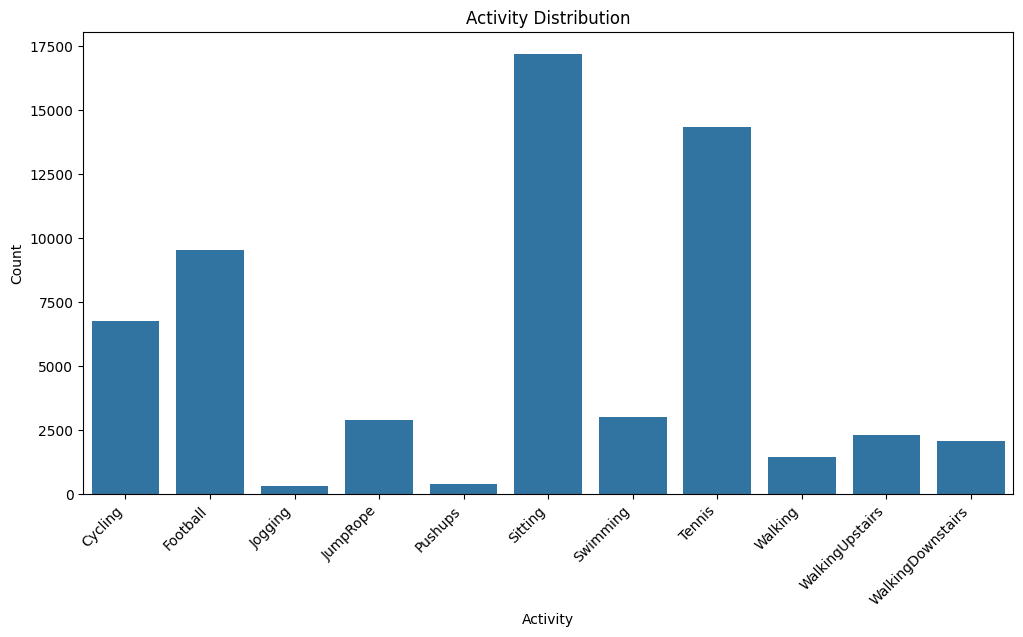

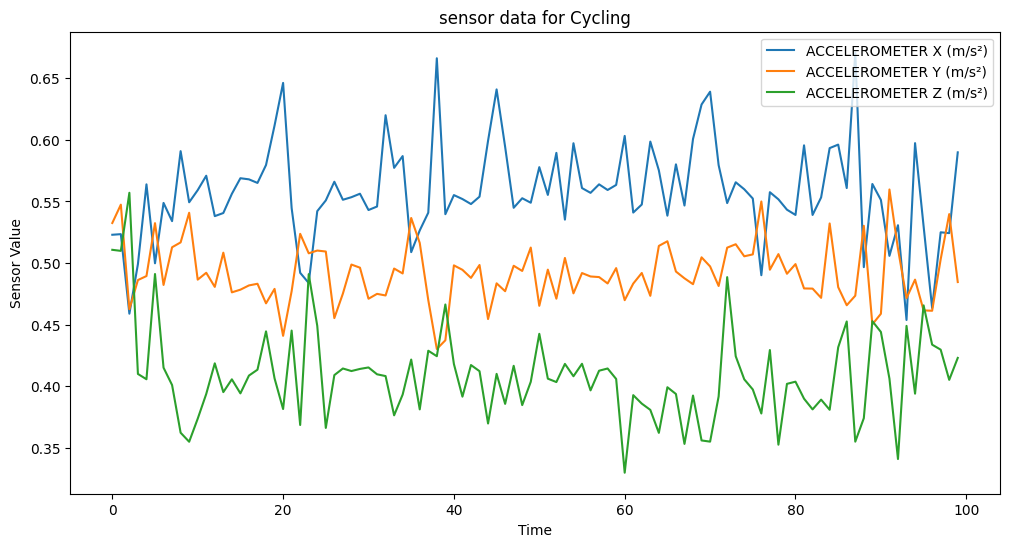

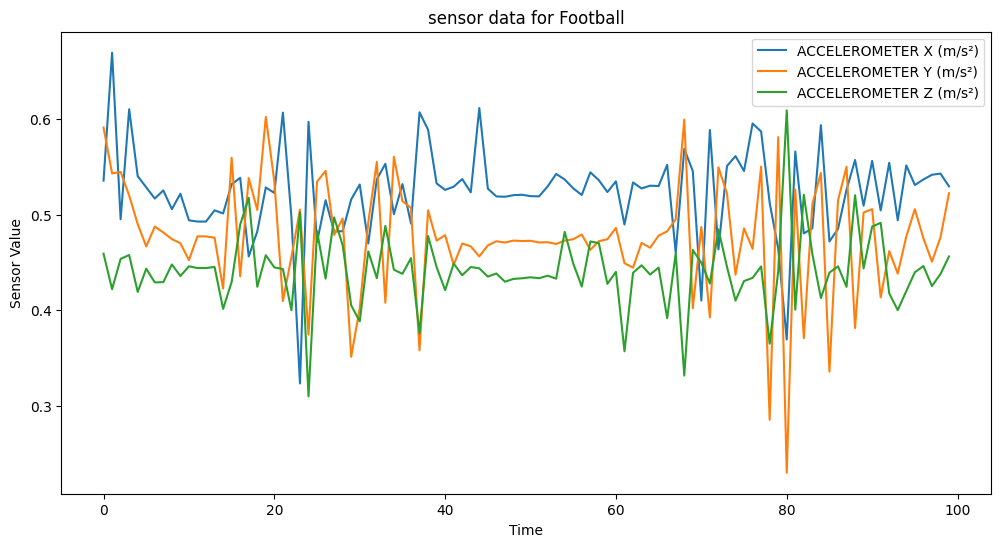

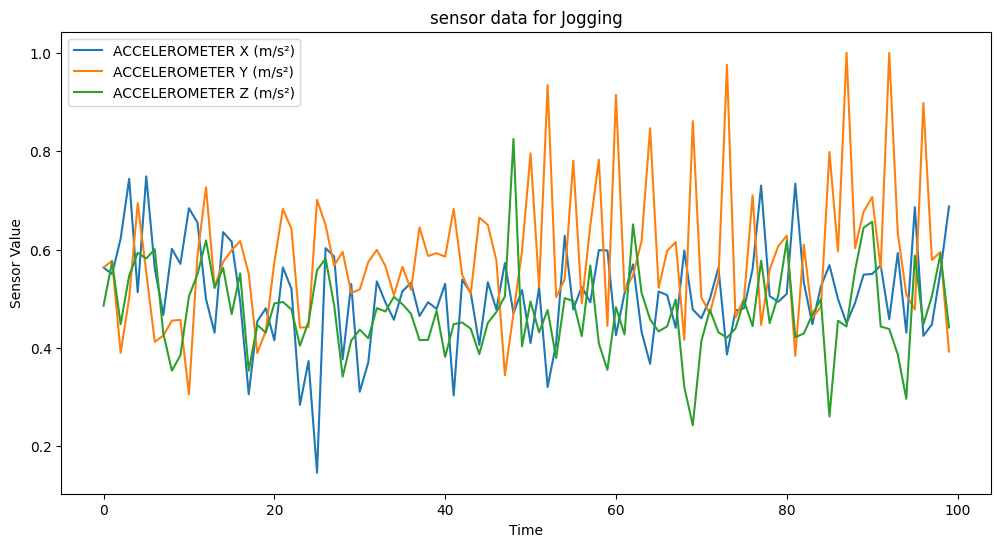

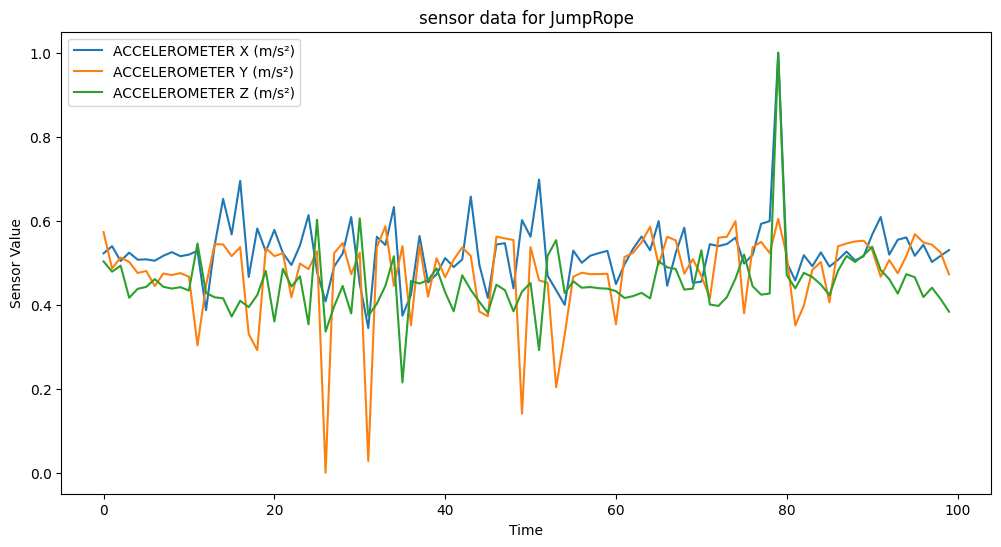

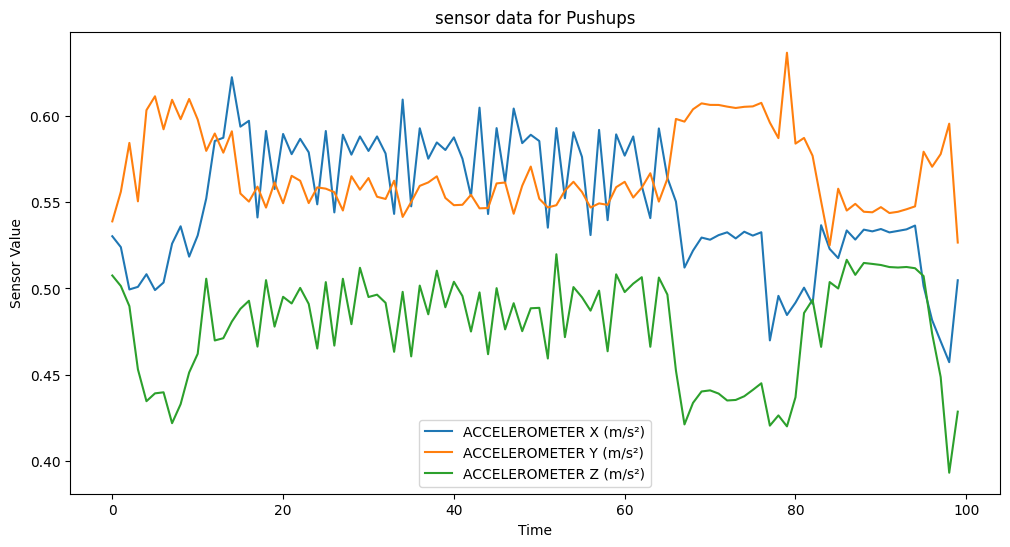

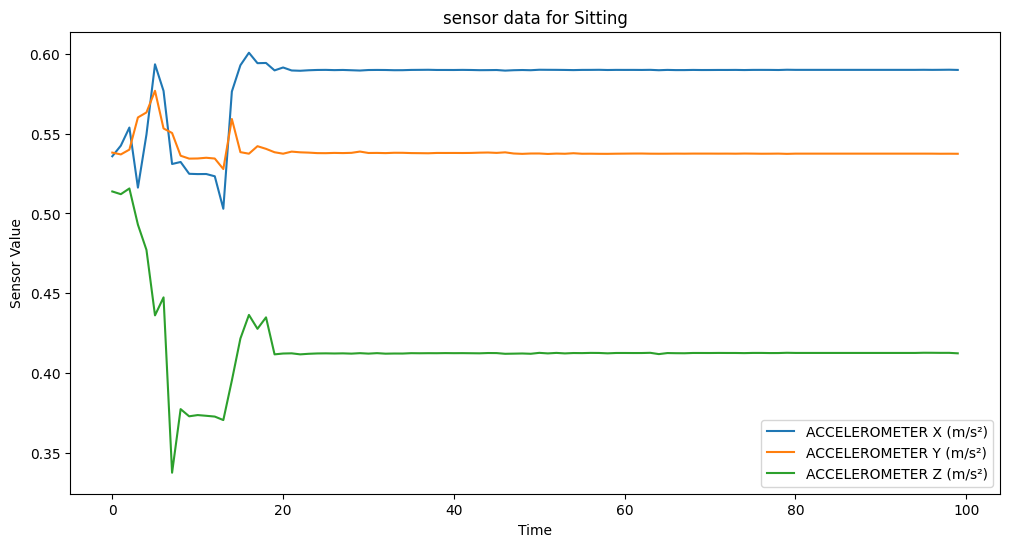

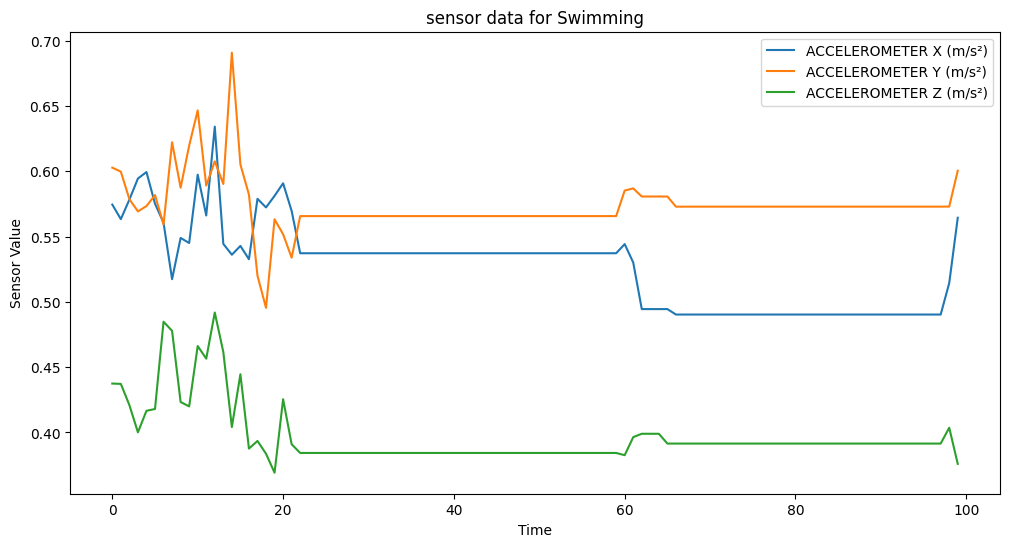

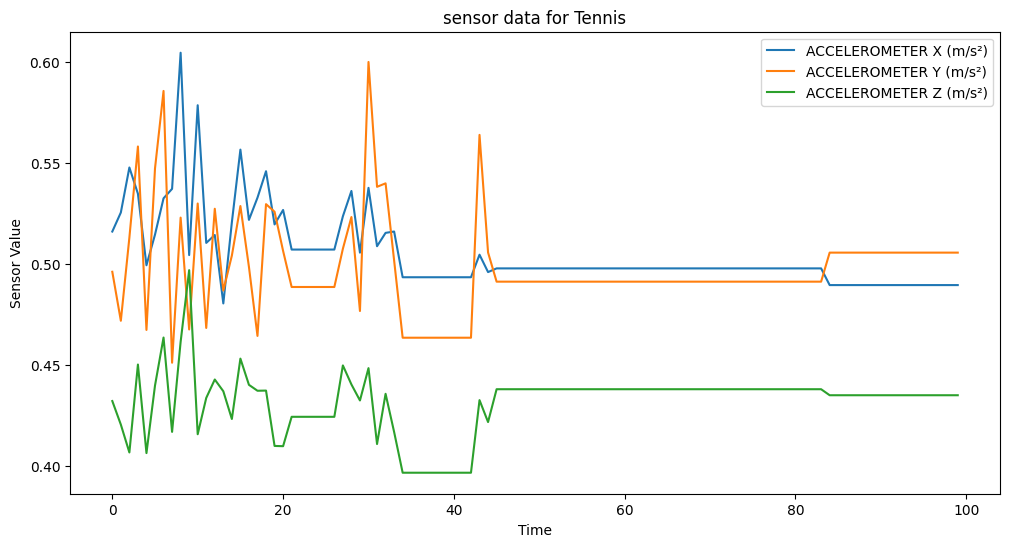

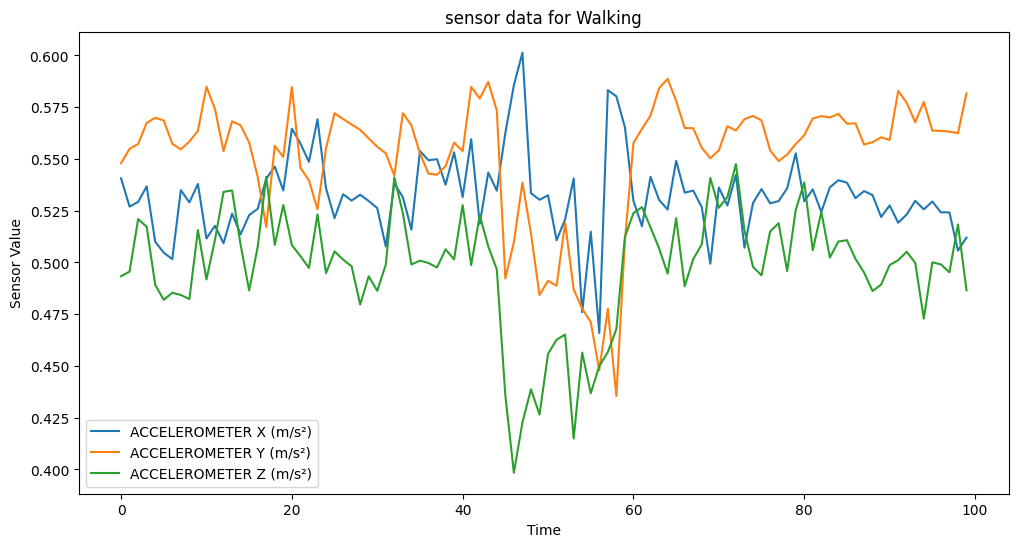

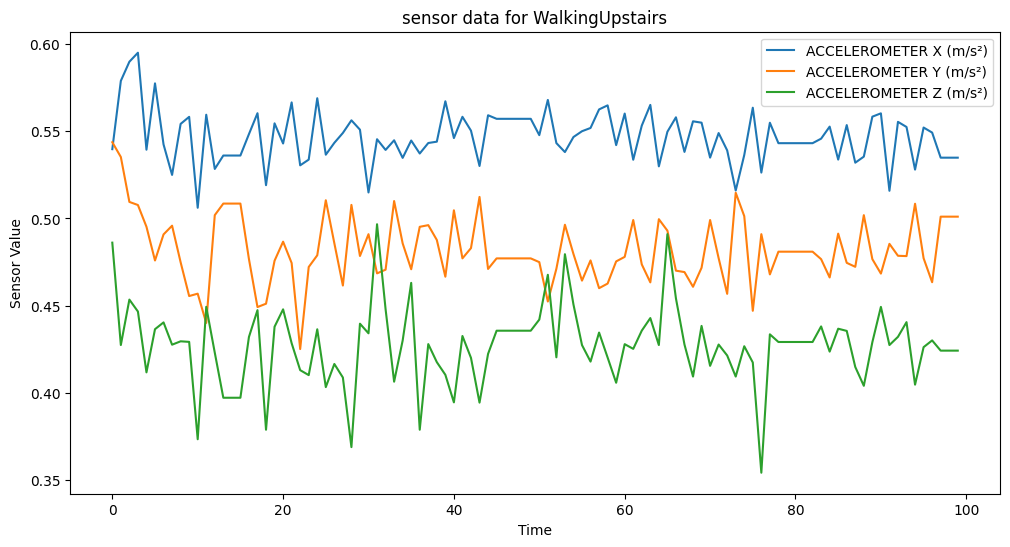

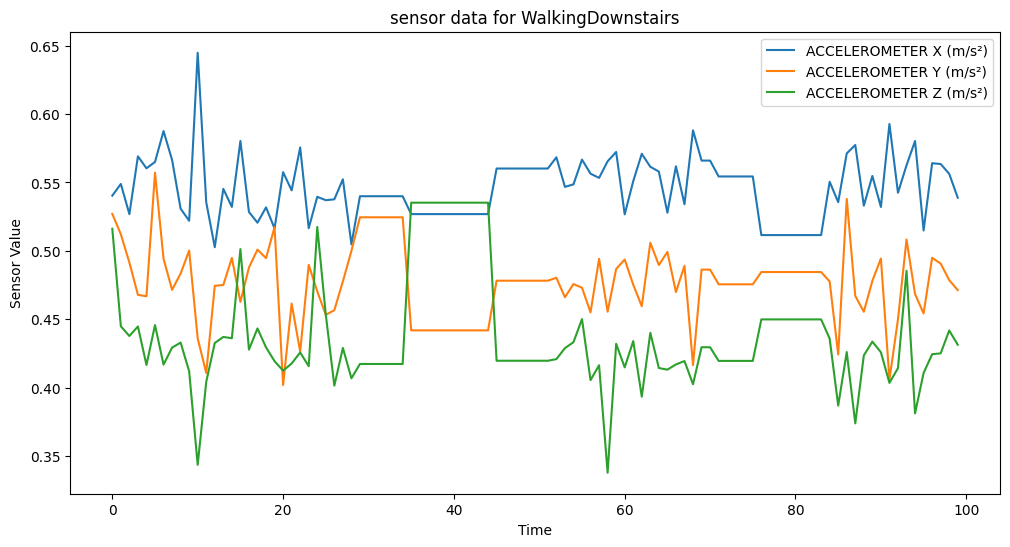

In [ ]:
# Activity distribution
plt.figure(figsize=(12, 6))
sns.countplot(x='activity', data=data)
plt.title('Activity Distribution')
plt.xlabel('Activity')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.show()

# Plot sensor data for all activities
activities_to_plot = data['activity'].unique() # Get unique activity labels from the DataFrame

for activity in activities_to_plot:
  subset = data[data['activity'] == activity]  # Filter by activity label
  plt.figure(figsize=(12, 6))
  num_points = 100
  x_values = np.arange(num_points)
  for sensor in ['ACCELEROMETER X (m/s²)', 'ACCELEROMETER Y (m/s²)', 'ACCELEROMETER Z (m/s²)']:
    plt.plot(x_values, subset[sensor][:num_points], label=sensor)  # Plot first 100 data points for clarity
  plt.title(f'sensor data for {activity}')
  plt.xlabel('Time')
  plt.ylabel('Sensor Value')
  plt.legend()
  plt.show()

# 6. Split the data for test and train

In [ ]:
X = data.drop(columns='activity') #features
y = data['activity'] #Target

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size =0.2, random_state=42, stratify=y)



#7. Model Selectin

Choose models like Random Forest, Gradient Boosting, or deep learning models like LSTMs.

Random Forest Classifier

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score


model = RandomForestClassifier(n_estimators=100, random_state= 42)

model.fit(X_train, y_train)

#Prediction
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")

                   precision    recall  f1-score   support

          Cycling       0.88      0.92      0.90      1353
         Football       0.95      0.96      0.95      1910
          Jogging       0.89      0.27      0.41        60
         JumpRope       0.88      0.84      0.86       580
          Pushups       0.77      0.69      0.73        84
          Sitting       1.00      1.00      1.00      3439
         Swimming       0.89      0.93      0.91       607
           Tennis       0.99      0.97      0.98      2872
          Walking       0.84      0.89      0.86       287
WalkingDownstairs       0.69      0.66      0.67       418
  WalkingUpstairs       0.66      0.72      0.69       465

         accuracy                           0.93     12075
        macro avg       0.86      0.80      0.82     12075
     weighted avg       0.93      0.93      0.93     12075

Accuracy: 0.9339130434782609


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score


#cross validation to check the performance of the RandomForestClassifier model
model = RandomForestClassifier(n_estimators=100, random_state= 42)
model.fit(X_train, y_train) # retraining the model
scores = cross_val_score(model, X_train, y_train, cv=5)

# Print the cross-validation scores
print("Cross-validation scores:", scores)

# Calculate and print the average accuracy
print("Average accuracy:", scores.mean())

Cross-validation scores: [0.93457557 0.93322981 0.93084886 0.93332643 0.93239466]
Average accuracy: 0.9328750666892163


Gradient Boosting model

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score, KFold

# Generate a synthetic dataset
X, y = make_classification(n_samples=1000, n_features=10, random_state=42)

#split the  data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

# Create and train the model
model = GradientBoostingClassifier(n_estimators = 100, learning_rate = 0.2, max_depth=3, random_state=42)

# Initialize KFold with the desired number of folds (e.g., 5)
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Perform cross-validation
scores = cross_val_score(model, X_train, y_train, cv=kf, scoring='accuracy')

# Print the cross-validation scores
print("Cross-validation scores:", scores)

# Calculate and print the average accuracy
print("Average accuracy:", scores.mean())

model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Cross-validation scores: [0.89375 0.88125 0.9     0.9     0.9125 ]
Average accuracy: 0.8975
Accuracy: 0.88
Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.88      0.87        89
           1       0.90      0.88      0.89       111

    accuracy                           0.88       200
   macro avg       0.88      0.88      0.88       200
weighted avg       0.88      0.88      0.88       200



LSTM Model

In [ ]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


# Encode target variable 'y_train' using LabelEncoder
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)  # Convert string labels to numerical labels
y_test = label_encoder.transform(y_test)

# Define the number of folds for cross-validation
n_splits = 5  # You can adjust this value

# Create a KFold object
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)  # Set random_state for reproducibility

# Initialize a list to store the accuracy scores from each fold
scores = []

# Iterate through the folds
for fold, (train_index, val_index) in enumerate(kf.split(X_train)):
    print(f"Fold {fold + 1}/{n_splits}")

    # Split data into training and validation sets for this fold
    # Use array-based indexing instead of .iloc
    X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
    y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

    # Reshape data for LSTM input
    X_train_fold_lstm = np.array(X_train_fold).reshape(X_train_fold.shape[0], X_train_fold.shape[1], 1)
    X_val_fold_lstm = np.array(X_val_fold).reshape(X_val_fold.shape[0], X_val_fold.shape[1], 1)

    # Build and compile the LSTM model (same as before)
    model = Sequential([
        LSTM(50, activation='relu', input_shape=(X_train_fold.shape[1], 1)),
        Dense(50, activation='relu'),
        Dense(len(np.unique(y_train)), activation='softmax')
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    # Train the model for this fold
    model.fit(X_train_fold_lstm, y_train_fold, epochs=50, batch_size=32, verbose=0)  # Set verbose=0 to suppress training output

    # Evaluate the model on the validation set for this fold
    _, accuracy = model.evaluate(X_val_fold_lstm, y_val_fold, verbose=0)  # Set verbose=0 to suppress evaluation output
    scores.append(accuracy)

    print(f"Fold accuracy: {accuracy}")

# Print the average accuracy across all folds
print(f"Average accuracy: {np.mean(scores)}")

Fold 1/5


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Fold accuracy: 0.8374999761581421
Fold 2/5
Fold accuracy: 0.8999999761581421
Fold 3/5
Fold accuracy: 0.887499988079071
Fold 4/5
Fold accuracy: 0.8062499761581421
Fold 5/5
Fold accuracy: 0.8687499761581421
Average accuracy: 0.8599999785423279


Combining models

As we get maximum accuracy in Gradiet boosting model and Random Forest Model. Hence, Now we will check if we get any change after combining both models.


In [ ]:
from sklearn.ensemble import VotingClassifier

rf_model = RandomForestClassifier(n_estimators=100, random_state=42).fit(X_train, y_train)
gb_model = GradientBoostingClassifier(n_estimators=100, random_state=42).fit(X_train, y_train)

# Combine models using VotingClassifier
voting_clf = VotingClassifier([
        ('rf', rf_model),
        ('gb', gb_model)
], voting='soft') #Soft for probability averaging

voting_clf.fit(X_train, y_train)

# Evaluate the ensemble model
y_pred = voting_clf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.86      0.96      0.91       100
           1       0.96      0.85      0.90       100

    accuracy                           0.91       200
   macro avg       0.91      0.91      0.90       200
weighted avg       0.91      0.91      0.90       200



### here we can see that the combination of Random Forest Model and Gradient Boosting is lower than the Random Forest alone so we will go with the Random Forest model only.

# 8. Optimize and fine Tunining

Using grid search or randomized search for hyperparameter optimization.

In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth' : [2, 5, 10, 20],
    'class_weight': ['balanced'],
    'min_samples_split': [5],
    'min_samples_leaf' : [2],
    'random_state' : [42]

}

grid_search = GridSearchCV(RandomForestClassifier(), param_grid, cv=3)

grid_search.fit(X_train, y_train)

print(grid_search.best_params_)

{'class_weight': 'balanced', 'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 50, 'random_state': 42}


In [ ]:
# Train final model with best parameters
optimized_rf = RandomForestClassifier(**grid_search.best_params_)
optimized_rf.fit(X_train, y_train)

# Evaluate the optimized model
y_pred = optimized_rf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.88      0.96      0.92       100
           1       0.96      0.87      0.91       100

    accuracy                           0.92       200
   macro avg       0.92      0.92      0.91       200
weighted avg       0.92      0.92      0.91       200



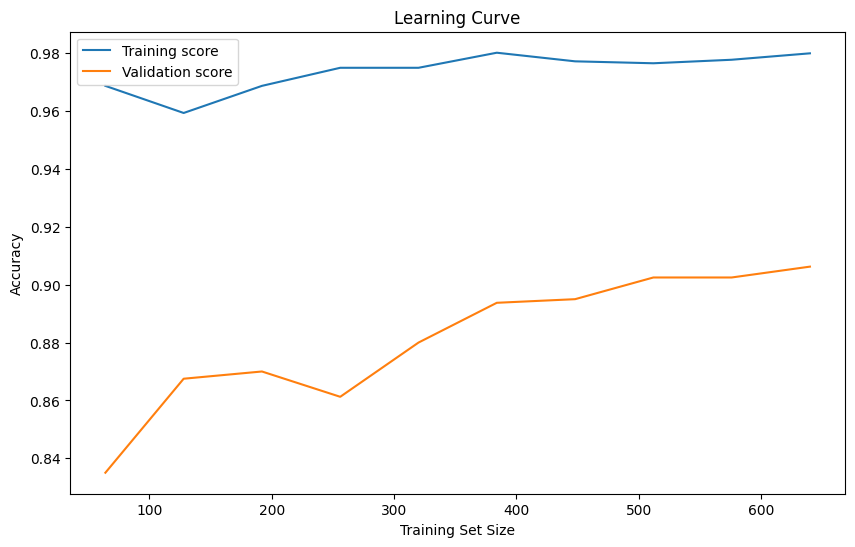

In [ ]:
from sklearn.model_selection import learning_curve
import numpy as np

train_sizes, train_scores, test_scores = learning_curve(
    optimized_rf, X_train, y_train, cv=5, scoring='accuracy', train_sizes=np.linspace(0.1, 1.0, 10))

# Calculate means
train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

# Plot learning curves
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores_mean, label="Training score")
plt.plot(train_sizes, test_scores_mean, label="Validation score")
plt.xlabel("Training Set Size")
plt.ylabel("Accuracy")
plt.title("Learning Curve")
plt.legend()
plt.show()


In [32]:
from sklearn.model_selection import cross_val_score


cv_scores = cross_val_score(optimized_rf, X_train, y_train, cv=20, scoring='accuracy')
print("Cross-Validation Accuracy:", cv_scores)
print("Mean Accuracy:", cv_scores.mean())

Cross-Validation Accuracy: [0.85  0.95  0.925 0.925 0.925 0.925 0.825 0.925 0.925 0.9   0.9   0.95
 0.925 0.9   0.9   0.95  0.975 0.9   0.85  0.925]
Mean Accuracy: 0.9125000000000002


Here we have acheived our desired accuracy. Hence, our model is ready for deployment.

# 9. Saving the model

In [33]:
import joblib

joblib.dump(model, 'har_model.pkl')
print("Model saved as 'har_model.pkl'")

Model saved as 'har_model.pkl'


## 9.1 Relaoding the model

In [34]:
loaded_model = joblib.load('har_model.pkl')
print("Model loaded successfully!")

Model loaded successfully!


Creating Fake input data to check the model.

In [35]:
new_data = [[0.5, 0.3, -0.2, 0.1, 0.2, 0.0, 0.6, 0.4, -0.3, 0.02, 0.03, -0.01]]

new_data = np.array(new_data)
new_data



array([[ 0.5 ,  0.3 , -0.2 ,  0.1 ,  0.2 ,  0.  ,  0.6 ,  0.4 , -0.3 ,
         0.02,  0.03, -0.01]])

making prediction.

In [36]:
prediction = loaded_model.predict(new_data)
print(f"Predicted activity: {prediction}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 325ms/step
Predicted activity: [[0.182417   0.81758296]]


Here we can see that our model is working with maxium accuracy.